1. Review the exercise
2. Talk about scaling with clustering
3. Clustering w/ categorical variables (spoiler: it depends)
4. 3d plotting

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

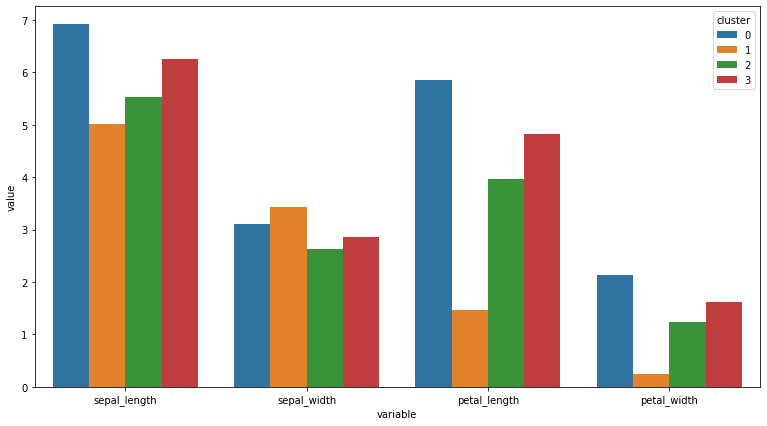

In [11]:
iris = sns.load_dataset('iris')
X = iris.drop(columns='species')
kmeans = KMeans(4).fit(X)

plt.figure(figsize=(13, 7))
(pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
 .reset_index()
 .rename(columns={'index': 'cluster'})
 .melt(id_vars='cluster')
 .pipe((sns.barplot, 'data'), y='value', x='variable', hue='cluster')
)

In [12]:
iris['cluster'] = kmeans.labels_

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


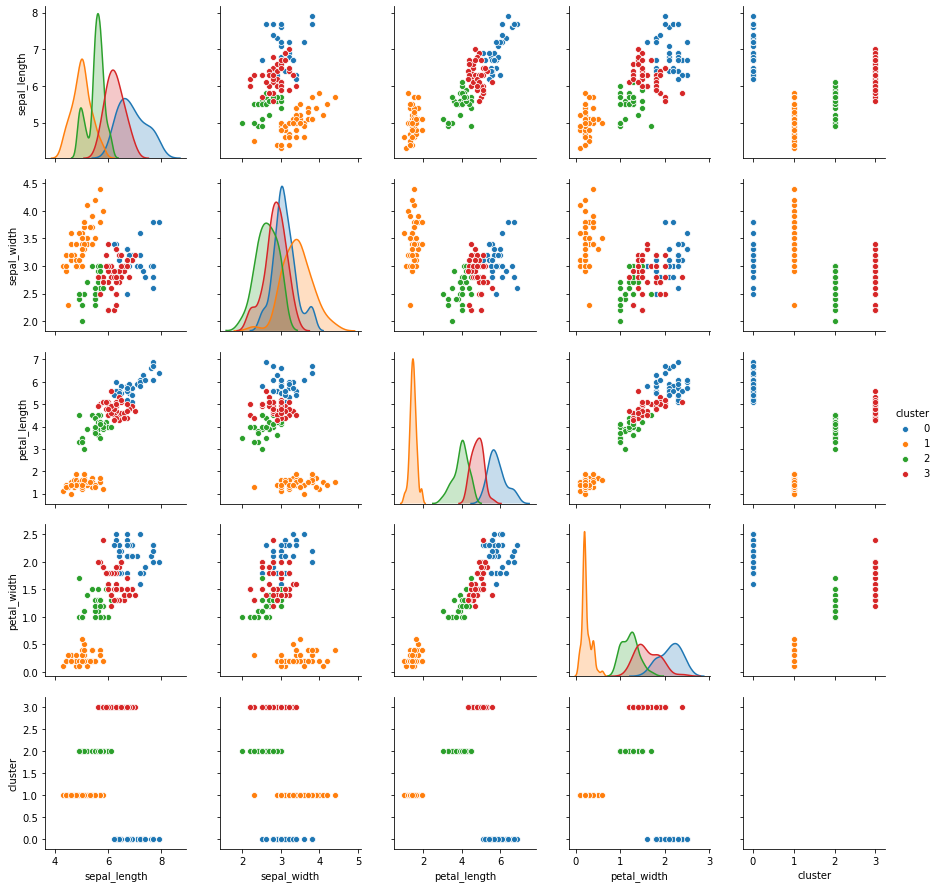

In [13]:
sns.pairplot(iris, hue='cluster')

## Mall Customer Data

In [14]:
import env

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/mall_customers'
query = 'SELECT * FROM customers'

customers = pd.read_sql(query, url)

In [15]:
customers.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


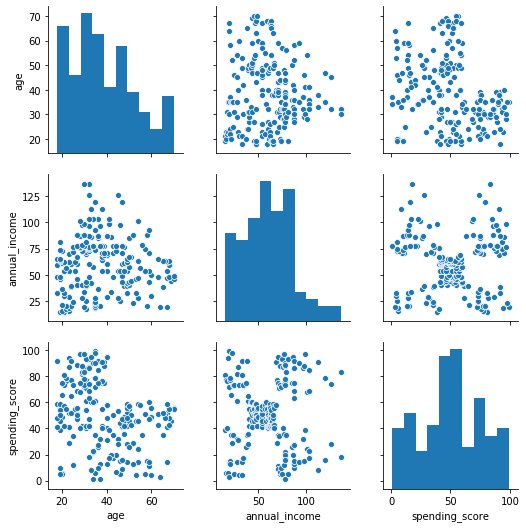

In [26]:
sns.pairplot(customers.drop(columns='customer_id'))

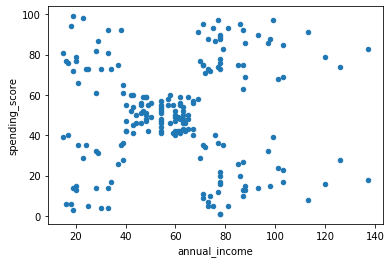

In [16]:
customers.plot.scatter(y='spending_score', x='annual_income')

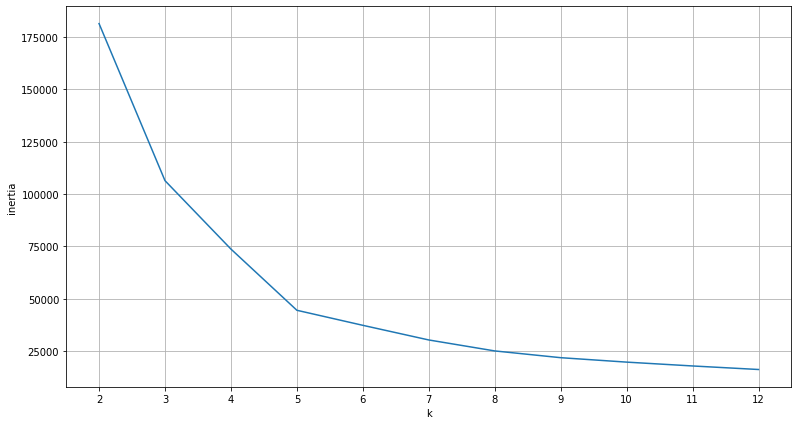

In [19]:
X = customers[['spending_score', 'annual_income']]

def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))
pd.Series({k: get_inertia(k) for k in range(2, 13)}).plot()
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [23]:
kmeans = KMeans(5).fit(X)
customers['cluster'] = kmeans.labels_
customers.cluster = 'cluster ' + customers.cluster.astype(str)

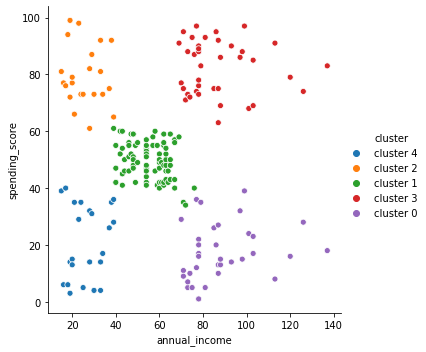

In [24]:
sns.relplot(data=customers, y='spending_score', x='annual_income', hue='cluster')

In [32]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(5).fit(X_scaled)

customers['cluster'] = kmeans.labels_

pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns)

,spending_score,annual_income
0,49.518519,55.296296
1,82.128205,86.538462
2,20.913043,26.304348
3,79.363636,25.727273
4,17.114286,88.200000


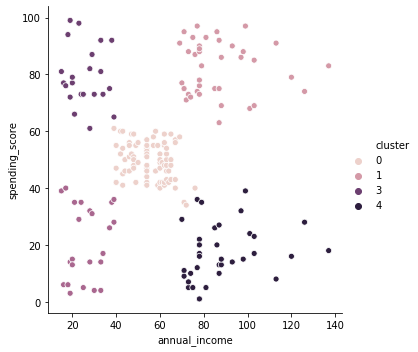

In [33]:
sns.relplot(data=customers, y='spending_score', x='annual_income', hue='cluster')

scaling demo: `tips` dataset -- cluster on tip and total bill

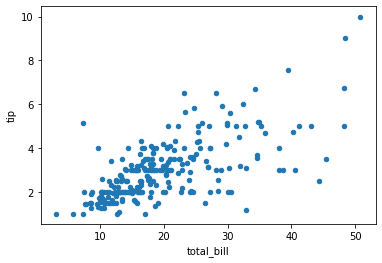

In [36]:
import pydataset

tips = pydataset.data('tips')
tips.plot.scatter(y='tip', x='total_bill')

In [37]:
X = tips[['total_bill', 'tip']]
kmeans = KMeans(5)
scaler = MinMaxScaler()

# unscaled clustering
kmeans.fit(X)
tips['unscaled_cluster'] = kmeans.labels_

# scaled clustering
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)
tips['scaled_cluster'] = kmeans.labels_

<Figure size 1152x648 with 0 Axes>

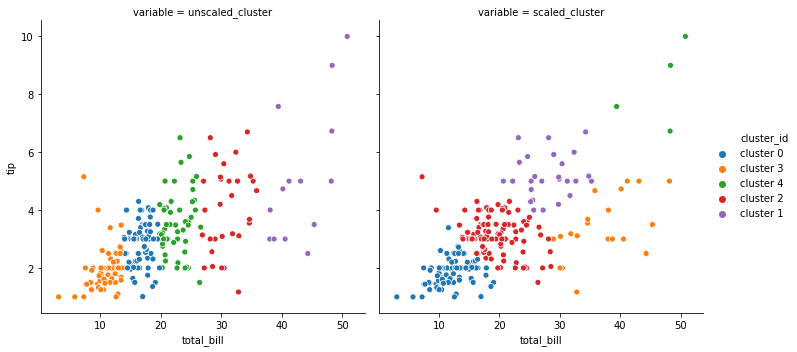

In [41]:
plt.figure(figsize=(16, 9))
(tips
 .melt(id_vars=['total_bill', 'tip'], value_vars=['unscaled_cluster', 'scaled_cluster'], value_name='cluster_id')
 .assign(cluster_id=lambda df: 'cluster ' + df.cluster_id.astype(str))
 .pipe((sns.relplot, 'data'), y='tip', x='total_bill', hue='cluster_id', col='variable')
)

## Clustering w/ a Categorical Variable

- distance metric
- algorithm

When you can encode a categorical variable as 0 or 1, you might have a reasonable interpretation when using kmeans clustering with that feature.

In [51]:
customers['is_female'] = (customers.gender == 'Female').astype(float)

In [56]:
X = customers.copy()[['spending_score', 'annual_income', 'is_female']]

scaler = MinMaxScaler(feature_range=(0, 3))
scaler.fit(X[['spending_score', 'annual_income']])
X.loc[:, ['spending_score', 'annual_income']] = scaler.transform(X[['spending_score', 'annual_income']])
X.head()

,spending_score,annual_income,is_female
0,1.163265,0.00000,0.0
1,2.448980,0.00000,0.0
2,0.153061,0.02459,1.0
3,2.326531,0.02459,1.0
4,1.193878,0.04918,1.0


In [58]:
kmeans = KMeans(5).fit(X)
customers['cluster'] = kmeans.labels_

In [65]:
np.c_[[1, 2, 3], [4, 5, 6]]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [68]:
m = np.c_[scaler.inverse_transform(kmeans.cluster_centers_[:, :2]), kmeans.cluster_centers_[:, -1]]
centroids = pd.DataFrame(m, columns=X.columns)
centroids.round(4)

,spending_score,annual_income,is_female
0,80.2381,25.6190,0.6190
1,42.5000,49.8281,1.0000
2,15.5937,89.4062,0.4375
3,43.9318,48.8409,0.0000
4,82.1282,86.5385,0.5385


<IPython.core.display.Javascript object>


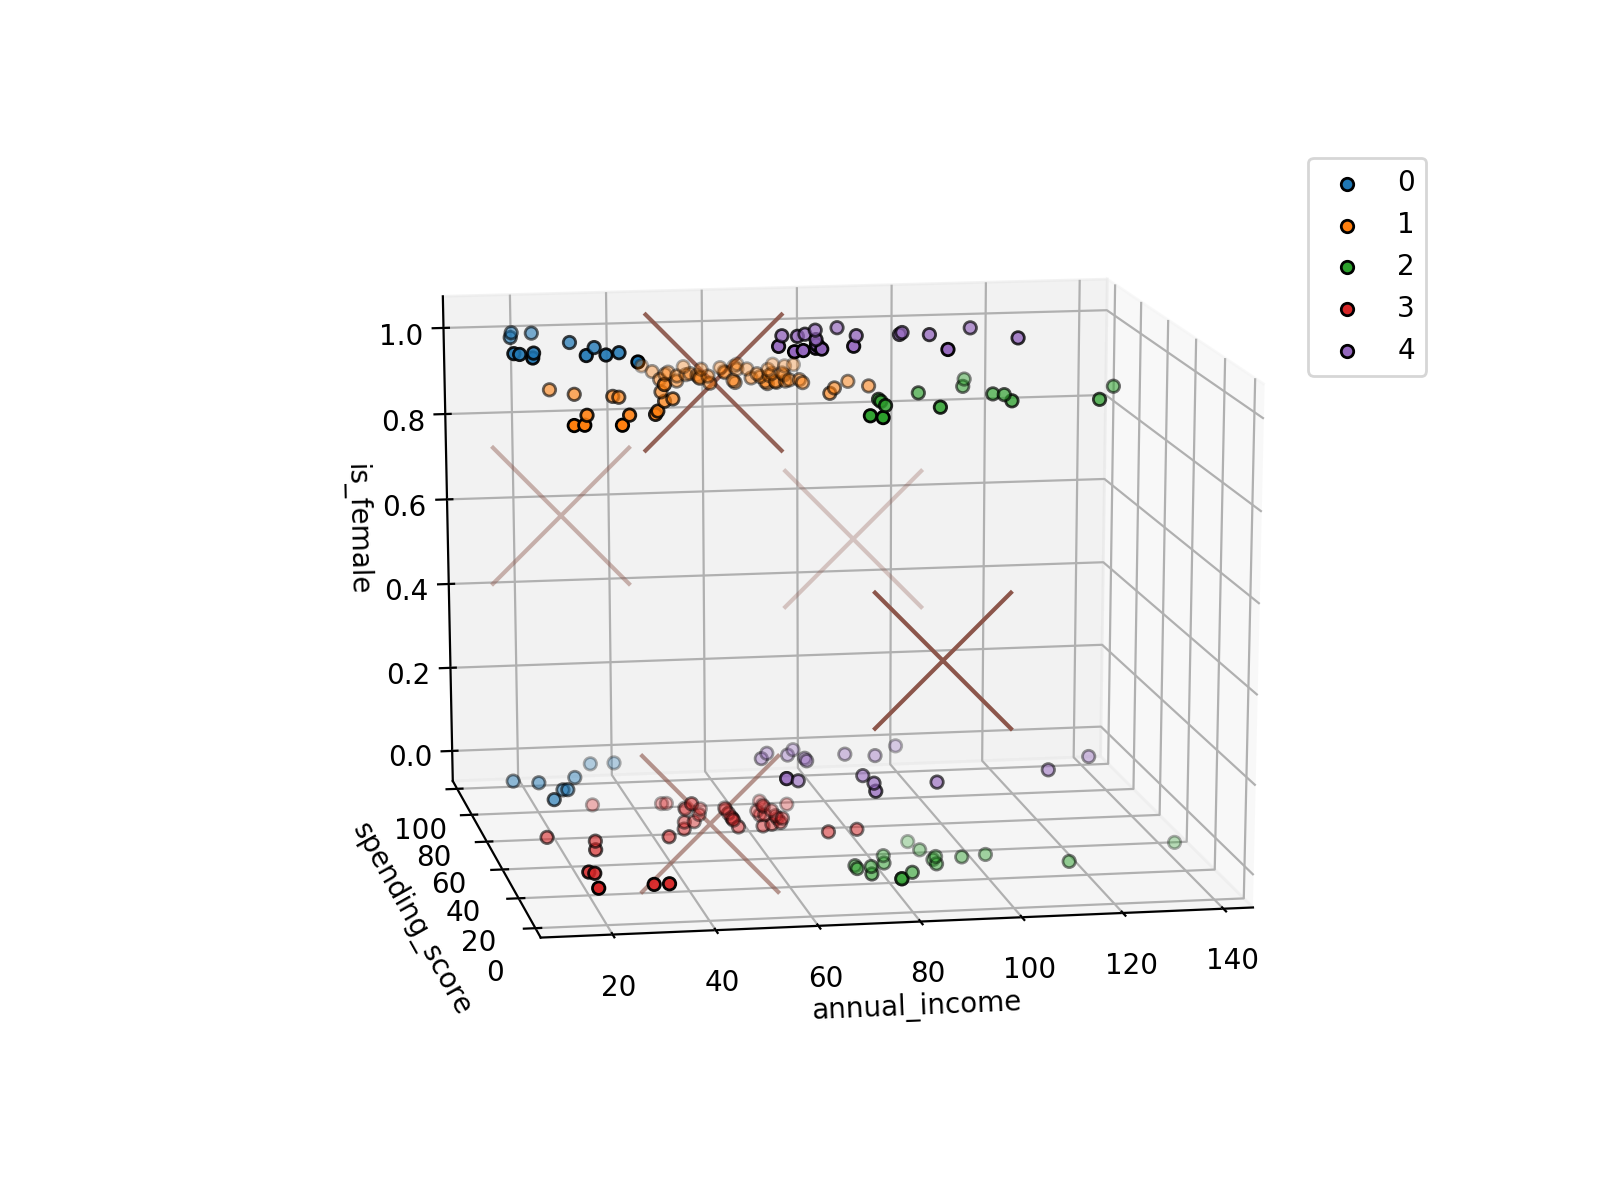

In [77]:
%matplotlib notebook

# 3d plotting
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
for cluster, subset in customers.groupby('cluster'):
    subset.gender = (subset.gender == 'Female').astype(float)
    ax.scatter(subset.annual_income, subset.spending_score, subset.gender, label=cluster, ec='black')
ax.legend()
ax.set(xlabel='annual_income', ylabel='spending_score', zlabel='is_female')
ax.scatter(centroids.annual_income, centroids.spending_score, centroids.is_female, marker='x', s=2500)

## Takeaways

- Visualize your clustering results
- Interpret your clusters through the cluster centers
- Clustering with categorical features is hard. When you have a categorical you can encode as a boolean, you might try kmeans, otherwise, don't use it for clustering.